# MRI Reconstruction: a comparison between classical and learning approaches

In this notebook we will try to reconstruct MR images using the Cascade-net [[1]](#ref1);

[1] <a id='ref1'></a> Schlemper, J., Caballero, J., Hajnal, J. V, Price, A., & Rueckert, D. (2018). A Deep Cascade of Convolutional Neural Networks for MR Image Reconstruction. IEEE Transactions on Medical Imaging, 37(2), 491–503. https://doi.org/10.1109/TMI.2017.2760978



In [4]:
!pip install git+https://github.com/zaccharieramzi/fastmri-reproducible-benchmark/ silence-tensorflow

  Cloning https://github.com/zaccharieramzi/fastmri-reproducible-benchmark/ to c:\users\panpan\appdata\local\temp\pip-req-build-vmr03fte
  Resolved https://github.com/zaccharieramzi/fastmri-reproducible-benchmark/ to commit 4a4ec09524437d11153fc5a525621783689bed38
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached silence_tensorflow-1.2.1.tar.gz (3.8 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached runstats-2.0.0-cp37-cp37m-win_amd64.whl (74 kB)
  Using cached tensorflow-2.8.0-cp37-cp37m-win_amd64.whl (437.9 MB)


  Running command git clone --filter=blob:none --quiet https://github.com/zaccharieramzi/fastmri-reproducible-benchmark/ 'C:\Users\PANPAN\AppData\Local\Temp\pip-req-build-vmr03fte'
ERROR: Could not find a version that satisfies the requirement tensorflow-nufft>=0.7.2 (from fastmri-recon) (from versions: none)
ERROR: No matching distribution found for tensorflow-nufft>=0.7.2


# A bit of context
MRI stands for Magnetic Resonance Imaging.
It is a medical imaging modality that is used to probe soft tissues inside the human body non-invasively and without the use of ionizing radiations.

However, MRI is particularly slow because it relies on the Magnetic Resonance phenomenon, which is inherently slow.
One way to speed up MRI is to acquire fewer signals (k-space shots ${\bf y}$), i.e. undersample.
If we do that, we find ourselves in a situation where we have not enough signals to reconstruct the image using simply the Inverse Fourier Transform ($F^{-1}$) as is typically done.
In fact, we have an ill-posed inverse problem that one must solve using priors on the MR images ${\bf x}$.

$$
F_{\Omega}{\bf x} = {\bf y}
$$

where $F_{\Omega}$ is a masked Fourier Transform with a mask $\Omega$ that selects the sampled lines in the k-space.

This means that we need a function to tell apart all the possible solutions of the inverse problem, that tells which solution is more likely to be an MR image.

In classical Compressed Sensing, these priors are handcrafted.
Deep Learning allows us to learn these priors from data.

In [1]:
%matplotlib inline
%env TF_CPP_MIN_LOG_LEVEL=3
import warnings
warnings.filterwarnings("ignore")

import io
import requests

from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from fastmri_recon.data.utils.crop import crop_center
from fastmri_recon.data.utils.masking.gen_mask import gen_mask
from fastmri_recon.evaluate.metrics.np_metrics import psnr, ssim
from fastmri_recon.models.functional_models.cascading import cascade_net
from fastmri_recon.models.subclassed_models.updnet import UPDNet

env: TF_CPP_MIN_LOG_LEVEL=3


In [2]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 6

In [3]:
np.random.seed(0)

## Outline

In this notebook, we will [load the data](#data), [retrospectively undersample it](#undersample), and then reconstruct it using the [Cascade-Net](#cascade)

# Data handling <a id='data'></a>

The data comes from the fastMRI database [[3]](#ref3). We selected the 16th slice of the first validation file (`file1000000`).

This image was not used when training the pretrained models we use in this demo notebook.

[3] <a id='ref3'></a> Zbontar, J., Knoll, F., Sriram, A., Muckley, M. J., Bruno, M., Defazio, A., … Lui, Y. W. (n.d.). fastMRI: An Open Dataset and Benchmarks for Accelerated MRI. Retrieved from https://arxiv.org/pdf/1811.08839.pdf

## Data loading

In [4]:
image = np.load(io.BytesIO(requests.get('https://github.com/zaccharieramzi/fastmri-reproducible-benchmark/raw/master/examples/gt_image.npy').content), allow_pickle=True)
kspace = np.load(io.BytesIO(requests.get('https://github.com/zaccharieramzi/fastmri-reproducible-benchmark/raw/master/examples/gt_kspace.npy').content), allow_pickle=True)

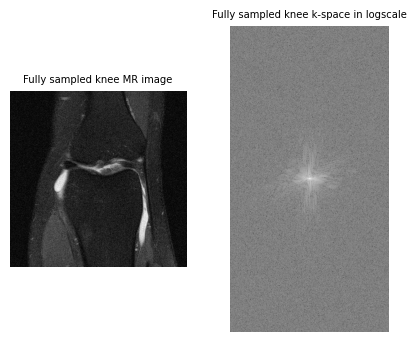

In [5]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image[..., 0])
axs[0].set_title('Fully sampled knee MR image')
axs[1].imshow(np.log(np.abs(kspace[..., 0])))
axs[1].set_title('Fully sampled knee k-space in logscale')
for i in [0, 1]:
    axs[i].axis('off');

## Retrospective undersampling <a id='undersample'></a>

In order to compare different reconstruction algorithms, i.e. algorithms that generate an MR image from undersampled data, we will simulate the acquisition of undersampled data via a retrospective undersampling.

In practice, this means that we multiply the original k-space by a binary mask in which the 1 entries correspond to the sampled points in the k-space and the 0 entries correspond to the non-sampled points.

In [6]:
AF = 4
mask = gen_mask(kspace[..., 0], accel_factor=AF, seed=0)
# the mas is received in fastmri format, we make a 1 and 0 mask in the fourier space
fourier_mask = np.repeat(mask.astype(np.float), kspace.shape[0], axis=0)
masked_kspace = fourier_mask[..., None] * kspace

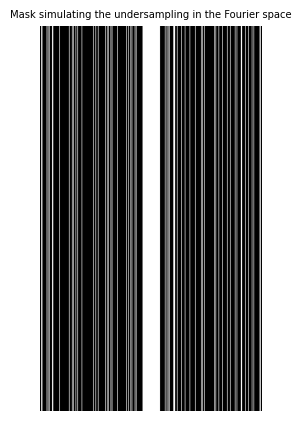

In [7]:
plt.figure()
plt.imshow(fourier_mask)
plt.axis('off')
plt.title('Mask simulating the undersampling in the Fourier space');

If one applies the Inverse Fourier Transform directly on the undersampled data, i.e. the masked out k-space, one obtains an aliased image.

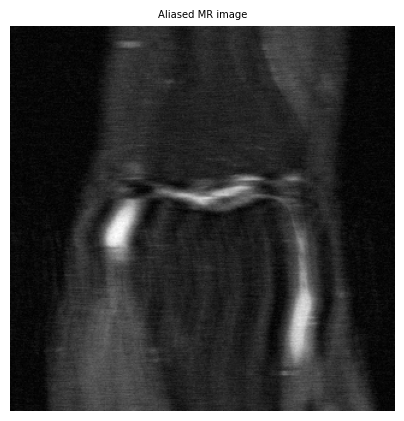

In [8]:
plt.figure()
plt.imshow(crop_center(np.abs(np.fft.fftshift(np.fft.ifft2(masked_kspace[..., 0], norm='ortho'))), 320))
plt.axis('off')
plt.title('Aliased MR image');

## Batching

Batching is necessary when using neural networks on both the training and the prediction steps.

In [9]:
mask_batch = fourier_mask[None, ...]
masked_kspace_batch = masked_kspace[None, ...]

## Scaling
Scaling was used for training to avoid numerical approximations that lead to poor training. Generally the inputs are normalized, but it was easier here to just scale them using the mean over the training set.

In [10]:
masked_kspace_batch *= 1e6  # 1e6 is the mean over the training set of the absolute kspace values.

# Reconstruction using the Cascade-net <a id='cascade'></a>

## Model loading

This model was trained on the [fastMRI 2D knee single coil dataset](https://fastmri.org/dataset/) with [the cascade-net training script from this repo](../fastmri_recon/training_scripts/single_coil/cascadenet_approach_af4.py).

In [11]:
run_params = {
    'n_cascade': 5,
    'n_convs': 5,
    'n_filters': 48,
    'noiseless': True,
}
model_name = 'CascadeNet-fastmri'

In [12]:
model = cascade_net(input_size=(None, None, 1), fastmri=True, **run_params)
model_weights_path = hf_hub_download(
    repo_id=f'zaccharieramzi/{model_name}',
    filename='model_weights.h5',
)
model.load_weights(model_weights_path)

Downloading: 100%|██████████| 1.83M/1.83M [00:00<00:00, 3.84MB/s]


## Reconstruction

In [13]:
%%time
cascade_reconstructed_image = model.predict_on_batch([masked_kspace_batch, mask_batch])

Wall time: 1.94 s


## Visual comparison

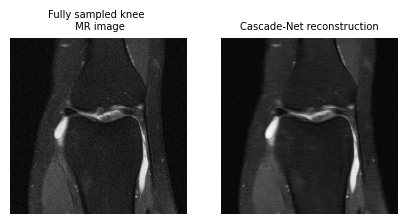

In [14]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].imshow(image[..., 0])
axs[0].set_title('Fully sampled knee \n MR image')
axs[1].imshow(cascade_reconstructed_image[0, ..., 0])
axs[1].set_title('Cascade-Net reconstruction')
for i in [0, 1]:
    axs[i].axis('off')